<a href="https://colab.research.google.com/github/Abdulrahmansheier/Data_Mining/blob/main/Data_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import os
import random
from collections import defaultdict
from pprint import pprint
import nltk
from nltk.corpus.reader import BNCCorpusReader
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics

from lxml import etree
import altair as al

In [ ]:
# Specifying the path directory
path = r"C:\Users\3mabd\Desktop\bnc2014spoken-xml\spoken"
dir_corpus_tagged = os.path.join(path, "tagged")
dir_corpus_untagged = os.path.join(path, "untagged")
dir_meta = os.path.join(path, "metadata")

# Managing data from the utternce data

In [ ]:
# First ill be printing the utterence data to view it from the untagged corpus

In [ ]:
def read(dir, xpath):
    f_names = os.listdir(dir)
    f_paths = [f"{dir}/{name}" for name in f_names]
    units = []

    for path in f_paths:
        block = pd.read_xml(path, xpath=xpath, encoding='utf-8')
        units.append(block)

    frame = pd.concat(units, axis=0, ignore_index=True)
    return frame

df = read(dir_corpus_untagged, '//u')
df

,n,who,u,unclear,trans,whoConfidence,vocal,foreign,anon,pause,trunc,shift,event
0,1,S0094,words,None,None,None,NaN,None,NaN,NaN,None,NaN,NaN
1,2,S0095,it's a games word? like a computer games word?,None,None,None,NaN,None,NaN,NaN,None,NaN,NaN
2,3,S0032,yeah yeah,None,None,None,NaN,None,NaN,NaN,None,NaN,NaN
3,4,S0095,oh,oh that's nice,None,None,NaN,None,NaN,NaN,None,NaN,NaN
4,5,S0032,I it's something I,have really heard,overlap,None,NaN,None,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248105,316,S0432,but,Mai Li,None,None,NaN,NaN,NaN,NaN,None,NaN,NaN
1248106,317,S0428,None,Sha Li,None,None,NaN,NaN,NaN,NaN,None,NaN,NaN
1248107,318,S0432,I'll just stick with it yeah,None,overlap,None,NaN,NaN,NaN,NaN,let,NaN,NaN
1248108,319,S0428,None,None,overlap,None,NaN,NaN,NaN,NaN,None,NaN,NaN


In [ ]:
# This code is for changing the type to string
df['u'] = df['u'].astype('string')
# This part is for remving any Null values
df =  df[df['u'] != '<NA>']

In [ ]:
# getting the number of missing data points per column
missing_values_count = df.isnull().sum()
# missing points in the columns
missing_values_count

n                      0
who                    0
u                      0
unclear          1103183
trans             891784
whoConfidence    1096240
vocal            1119744
foreign          1119262
anon             1119744
pause            1119744
trunc            1068040
shift            1119744
event            1119744
dtype: int64

In [ ]:
# remove all the rows that contain a missing value
df = df.dropna(axis=1)

In [ ]:
# get the number of missing data points per column in the utterance
missing_values_count = df.isnull().sum()
# missing points in the columns
missing_values_count

n      0
who    0
u      0
dtype: int64

In [ ]:
# Inspecting the U file after removing the columns with the missing values
df

,n,who,u
0,1,S0094,words
1,2,S0095,it's a games word? like a computer games word?
2,3,S0032,yeah yeah
3,4,S0095,oh
4,5,S0032,I it's something I
...,...,...,...
1248099,310,S0432,yeah
1248100,311,S0428,Little Jasmine
1248105,316,S0432,but
1248107,318,S0432,I'll just stick with it yeah


In [ ]:
# group data by speaker and calculate mean utterance length per speaker
mean_utterance_length = df.groupby('who')['u'].apply(lambda x: x.str.len().mean())
print(mean_utterance_length)

who
S0001        27.627119
S0002        26.239700
S0003        27.650602
S0004        32.746130
S0005        30.714286
               ...    
S0691        27.050000
S0692        21.859756
UNKFEMALE    17.482796
UNKMALE      19.669201
UNKMULTI      6.035928
Name: u, Length: 671, dtype: float64


In [ ]:
# choosing the three columns in the utterence table
df_utterence = df[['n', 'who', 'u']]

# create summary statistics table
summary_statistics = df_utterence.describe(percentiles=[0.25, 0.5, 0.75]).transpose()
# adding the range column to summary table
summary_statistics['range'] = summary_statistics['max'] - summary_statistics['min']
# reorder columns
summary_statistics = summary_statistics[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range']]

# print summary table
print(summary_statistics)


       count        mean          std  min    25%    50%     75%      max  \
n  1119744.0  947.209766  1324.344264  1.0  252.0  586.0  1205.0  16574.0   

     range  
n  16573.0  


# Managing data from the speakers data

In [ ]:
# printing the speakers data to view it

In [ ]:
def read(dir, xpath):
    f_names = os.listdir(dir)
    f_paths = [f"{dir}/{name}" for name in f_names]
    units = []

    for path in f_paths:
        block = pd.read_xml(path, xpath=xpath, encoding='utf-8')
        units.append(block)

    frame = pd.concat(units, axis=0, ignore_index=True)
    return frame

df_speaker = read(dir_corpus_untagged, '//speaker')
df_speaker

,id,exactage,age1994,agerange,gender,nat,birthplace,birthcountry,l1,lingorig,...,dialect_l2,dialect_l3,dialect_l4,edqual,occupation,socgrade,nssec,l2,fls,in_core
0,S0021,27,25_34,19_29,F,British,Swindon,England,English,England,...,england,south,southwest,5_postgrad,Teacher,B,2,None,None,y
1,S0032,28,25_34,19_29,M,British,Yoevil,England,English,England,...,england,south,southwest,4_graduate,Software developer,A,1_2,None,None,y
2,S0094,33,25_34,30_39,F,British,Swindon,England,English,England,...,england,south,southwest,5_postgrad,PhD student,A,1_2,German,Welsh -- Beginner,y
3,S0095,33,25_34,30_39,M,British,Camarthen,Scotland,English,England,...,wales,wales,wales,5_postgrad,Self employed maker,E,uncat,None,None,y
4,S0261,41,35_44,40_49,M,British/New Zealand,Wellington,New Zealand,English,England/NZ,...,non_uk,non_uk,non_uk,4_graduate,Entrepreneur,A,1_2,NaN,None,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588,S0510,47,45_59,40_49,F,British,England,England,English,England,...,england,south,unspecified,5_postgrad,Receptionist,D,6,NaN,NaN,y
3589,S0058,23,15_24,19_29,F,British,"Sunderland, Tyne and Wear",England,English,England,...,england,north,northeast,4_graduate,Corpus Administrator,B,2,NaN,None,n
3590,S0120,23,15_24,19_29,M,British & German,"Pembury, Kent",England,English,England,...,england,south,unspecified,5_postgrad,Graduate Civil Engineer,C1,4,NaN,German -- Advanced; French -- Advanced,n
3591,S0428,27,25_34,19_29,F,British,"Aylesbury, Buckinghamshire",England,English,England,...,england,south,eastern_engl,5_postgrad,Language Research Co-ordinator,A,1_2,NaN,Spanish -- level unspecified; Italian -- level...,y


In [ ]:
# select age-related columns / columns of interest
age_columns = ['exactage']
#exactage' converting it to a numeric type using the pd.to_numeric function
df_speaker[age_columns] = df_speaker[age_columns].apply(pd.to_numeric, errors='coerce')
# create summary statistics table
summary_statistics = df_speaker[age_columns].describe(percentiles=[0.25, 0.5, 0.75]).transpose()
# add range column to summary table
summary_statistics['range'] = summary_statistics['max'] - summary_statistics['min']
# reorder columns
summary_statistics = summary_statistics[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range']]
# print summary table
print(summary_statistics)


           count       mean        std  min   25%   50%   75%   max  range
exactage  3233.0  37.603155  19.605057  2.0  21.0  36.0  53.0  91.0   89.0


In [ ]:
# remove all columns with at least one missing value
columns_with_na_dropped = df_speaker.dropna(axis=1)
columns_with_na_dropped.head()

,id,age1994,agerange,gender,dialect_rep,dialect_l1,dialect_l2,dialect_l3,dialect_l4,edqual,socgrade,nssec,in_core
0,S0021,25_34,19_29,F,West Country,uk,england,south,southwest,5_postgrad,B,2,y
1,S0032,25_34,19_29,M,South West,uk,england,south,southwest,4_graduate,A,1_2,y
2,S0094,25_34,30_39,F,West Country,uk,england,south,southwest,5_postgrad,A,1_2,y
3,S0095,25_34,30_39,M,Slightly Welsh,uk,wales,wales,wales,5_postgrad,E,uncat,y
4,S0261,35_44,40_49,M,Kiwi English,non_uk,non_uk,non_uk,non_uk,4_graduate,A,1_2,n


#  Extracting the columns from df_speaker and merging it to Utternce

In [ ]:
age_columns = ['exactage', 'age1994', 'agerange']
df_age = df_speaker[age_columns]

In [ ]:
# getting the speaker data
df_speaker = read(dir_corpus_untagged, '//speaker')
# selecting age-related columns
age_columns = ['exactage', 'age1994', 'agerange']

# merge age-related columns to df
df_new = pd.concat([df, df_speaker[age_columns]], axis=1)
df_new

,n,who,u,exactage,age1994,agerange
0,1.0,S0094,words,27,25_34,19_29
1,2.0,S0095,it's a games word? like a computer games word?,28,25_34,19_29
2,3.0,S0032,yeah yeah,33,25_34,30_39
3,4.0,S0095,oh,33,25_34,30_39
4,5.0,S0032,I it's something I,41,35_44,40_49
...,...,...,...,...,...,...
3557,NaN,NaN,<NA>,59,45_59,50_59
3558,NaN,NaN,<NA>,32,25_34,30_39
3567,NaN,NaN,<NA>,59,45_59,50_59
3569,NaN,NaN,<NA>,23,15_24,19_29


# Cleaning the new dataframe created

In [ ]:
df_new = pd.concat([df, df_speaker[age_columns]], axis=1)
df_new = df_new.dropna(subset=['who', 'exactage','age1994','agerange'])


In [ ]:
# viewing the new dataframe made
df_new

,n,who,u,exactage,age1994,agerange
0,1.0,S0094,words,27,25_34,19_29
1,2.0,S0095,it's a games word? like a computer games word?,28,25_34,19_29
2,3.0,S0032,yeah yeah,33,25_34,30_39
3,4.0,S0095,oh,33,25_34,30_39
4,5.0,S0032,I it's something I,41,35_44,40_49
...,...,...,...,...,...,...
3588,3589.0,S0032,blow to bits,47,45_59,40_49
3589,3590.0,S0094,yeah that's the only one that like makes sense,23,15_24,19_29
3590,3591.0,S0021,well I use gib in a very different like meanin...,23,15_24,19_29
3591,3592.0,S0032,what meaning do you use?,27,25_34,19_29


After creating the new dataframe, I wanted to print summary statistics for all columns together. This means that I wanted to see the values of each statistical measure (such as mean, median, and standard deviation) for each column in a tabular format. By doing this, I can quickly compare the values of each column and identify any differences or similarities between them.

In [ ]:
columns = ['n', 'who', 'u', 'exactage', 'age1994', 'agerange']
table_data = df_new[columns].applymap(lambda x: len(str(x)))
table_data[columns].describe()


,n,who,u,exactage,age1994,agerange
count,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000
mean,5.696238,5.092673,24.012277,1.959604,5.086733,4.943366
std,0.524372,0.551009,26.864813,0.293808,0.503555,0.231187
min,3.000000,5.000000,1.000000,1.000000,4.000000,4.000000
25%,5.000000,5.000000,4.000000,2.000000,5.000000,5.000000
50%,6.000000,5.000000,15.000000,2.000000,5.000000,5.000000
75%,6.000000,5.000000,33.000000,2.000000,5.000000,5.000000
max,6.000000,9.000000,206.000000,4.000000,6.000000,5.000000


from the above tabular data we can extract that the average utterance is 24.012277

# Graphs are made for visualization of the new data

In [ ]:
# Split age range column into min and max age columns
df_new[['min_age', 'max_age']] = df_new['agerange'].str.split('_', expand=True)

# Convert age columns to integer data type
df_new['exactage'] = pd.to_numeric(df_new['exactage'], errors='coerce')
df_new['min_age'] = pd.to_numeric(df_new['min_age'], errors='coerce')
df_new['max_age'] = pd.to_numeric(df_new['max_age'], errors='coerce')

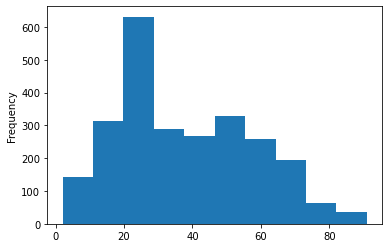

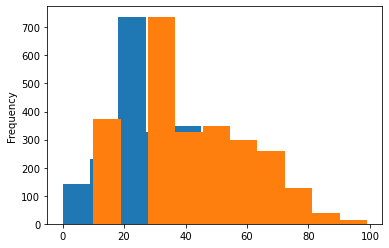

In [ ]:
# Create histogram of exact age
df_new['exactage'].plot.hist()
plt.show()
# Create histogram of age range
df_new['min_age'].plot.hist()
df_new['max_age'].plot.hist()
plt.show()

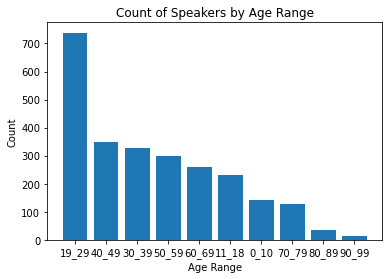

In [ ]:
# In this bar chart it is made to show the number of speakers within the age range
age_range_counts = df_new['agerange'].value_counts()
plt.bar(age_range_counts.index, age_range_counts.values)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Count of Speakers by Age Range')
plt.show()


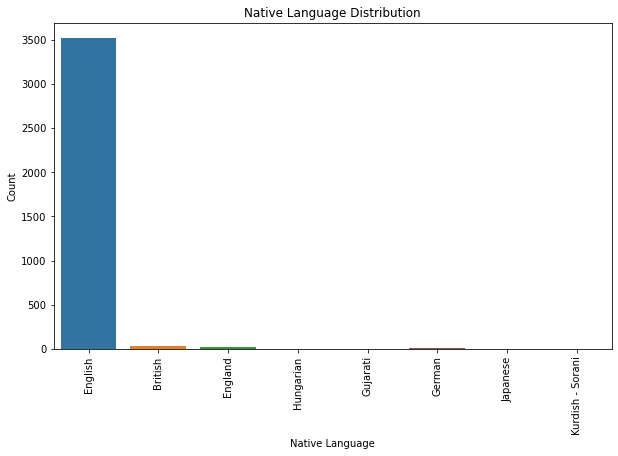

In [ ]:
# bar plot showing the First language count of speakers
plt.figure(figsize=(10, 6))
sns.countplot(x='l1', data=df_speaker)
plt.xlabel('Native Language')
plt.ylabel('Count')
plt.title('Native Language Distribution')
plt.xticks(rotation=90)
plt.show()


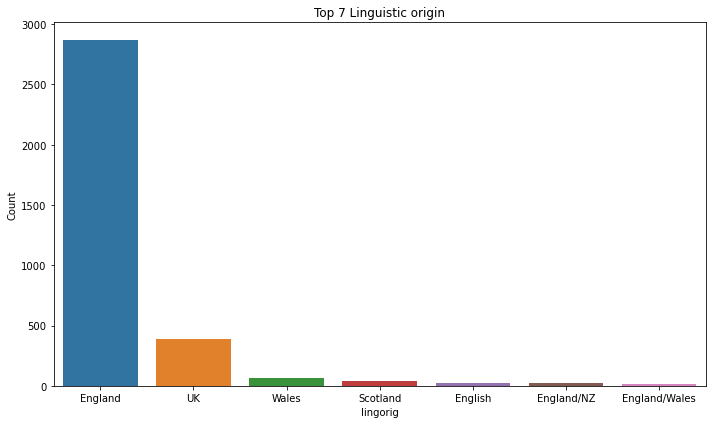

In [ ]:
# Making a histogram to see the difference of utterence on the region Linguistic origin

plt.figure(figsize=(10, 6))
sns.countplot(data=df_speaker, x='lingorig', order=df_speaker['lingorig'].value_counts().head(7).index)
plt.xlabel('lingorig')
plt.ylabel('Count')
plt.title('Top 7 Linguistic origin')
plt.tight_layout()
plt.show()

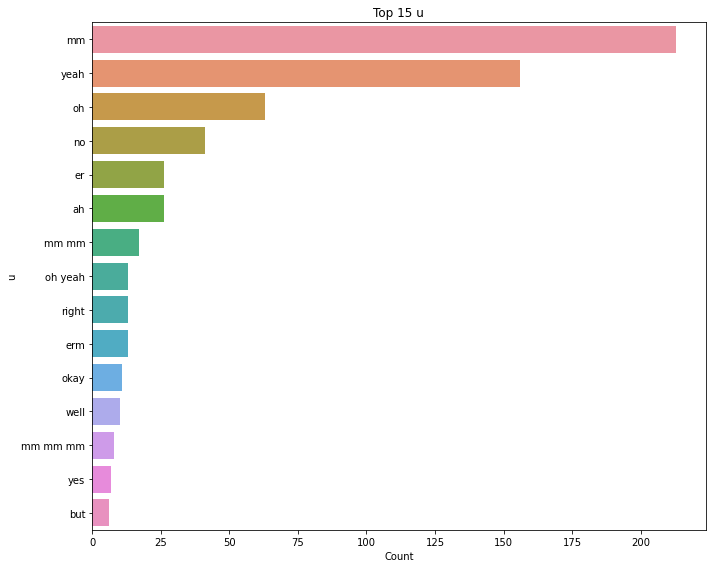

In [ ]:
#showing the most common words between the speakers
plt.figure(figsize=(10, 8))
sns.countplot(data=df_new, y='u', order=df_new['u'].value_counts().head(15).index)
plt.xlabel('Count')
plt.ylabel('u')
plt.title('Top 15 u')
plt.tight_layout()
plt.show()


# Training a simple classifier

In [ ]:
#train_set, test_set = train_test_split(df_new, test_size=0.2)
#train_set, test_set

# Here i would be addding the logistic regression and getting its Validation Accuracy

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Split the dataset into features (X) and target (y)
X_text = df_new['u'].values
y = df_new['agerange'].values

# Split the data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=8)

# Convert text data which is the utterence to numerical representation using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Train the logistic regression classifier
classifier = LogisticRegression(max_iter=128)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
accuracy = classifier.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.25742574257425743


# Splitting the data

# Here Examining errors by calling the precision, recall, f1-score, support

In [ ]:
# precision, recall, F1-score, and support
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

        0_10       0.00      0.00      0.00        23
       11_18       0.07      0.02      0.04        42
       19_29       0.32      0.63      0.42       167
       30_39       0.20      0.17      0.19        63
       40_49       0.24      0.10      0.15        67
       50_59       0.11      0.07      0.09        58
       60_69       0.03      0.02      0.03        41
       70_79       0.00      0.00      0.00        30
       80_89       0.00      0.00      0.00         9
       90_99       0.00      0.00      0.00         5

    accuracy                           0.26       505
   macro avg       0.10      0.10      0.09       505
weighted avg       0.18      0.26      0.20       505



C:\Users\3mabd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\3mabd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\3mabd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.09729080741316559
Recall: 0.10309766104189708
Confusion Matrix:
 [[  0   0  18   2   1   0   2   0   0   0]
 [  0   1  33   3   2   1   2   0   0   0]
 [  1   5 106  20  12   9  14   0   0   0]
 [  1   1  40  11   0   7   3   0   0   0]
 [  1   1  43   5   7   3   7   0   0   0]
 [  1   4  37   7   2   4   2   1   0   0]
 [  0   0  27   3   4   6   1   0   0   0]
 [  1   1  21   2   1   4   0   0   0   0]
 [  0   2   4   2   0   0   0   1   0   0]
 [  0   0   4   0   0   1   0   0   0   0]]


C:\Users\3mabd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


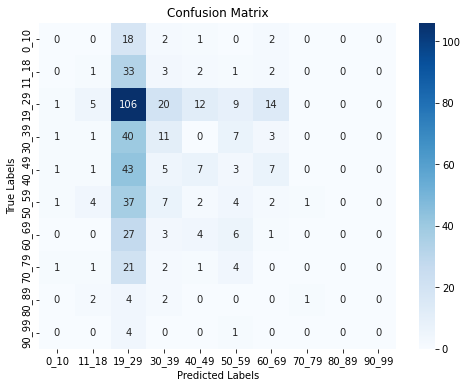

In [ ]:
# precision, recall, and confusion matrix for the logistic regression
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
confusion = confusion_matrix(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", confusion)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Adding the Random forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Convert text data to numerical representation using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

# Random Forest Classifier being specified
complex_model = RandomForestClassifier(n_estimators=100)
complex_model.fit(X_train, y_train)
# Predictions on the validation set
y_val_pred = complex_model.predict(X_val)

In [ ]:
y_val_pred = np.array(y_val_pred).flatten()
y_val = np.array(y_val).flatten()

# accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='macro')
recall = recall_score(y_val, y_val_pred, average='macro')
confusion_mat = confusion_matrix(y_val, y_val_pred)

C:\Users\3mabd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* getting the accuracy score on the validation set
* precision, recall, and confusion matrix readings

In [ ]:
# Calculate the validation accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
# Calculate the validation precision and validation recall
precision = precision_score(y_val, y_val_pred, average='macro')
print("Validation Precision: {:.2f}".format(precision))
recall = recall_score(y_val, y_val_pred, average='macro')
print("Validation Recall: {:.2f}".format(recall))

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion_mat)


# Error analysis
misclassified_samples = X_val[y_val != y_val_pred]
misclassified_labels = y_val[y_val != y_val_pred]
print("Misclassified Samples:")
print(misclassified_samples)
print("Misclassified Labels:")
print(misclassified_labels)

Validation Accuracy: 21.78%
Validation Precision: 0.10
Validation Recall: 0.09
Confusion Matrix:
[[ 1  2 15  1  1  0  3  0  0  0]
 [ 0  4 29  4  1  1  2  1  0  0]
 [ 5 15 90 20 23  8  4  2  0  0]
 [ 2  4 36  6  6  8  1  0  0  0]
 [ 1  4 47  4  5  1  5  0  0  0]
 [ 0  5 36  8  4  3  1  0  1  0]
 [ 0  5 24  3  5  2  0  1  1  0]
 [ 0  1 18  5  1  2  2  1  0  0]
 [ 1  1  4  1  0  1  0  1  0  0]
 [ 2  0  3  0  0  0  0  0  0  0]]
Misclassified Samples:
  (0, 854)	1
  (0, 988)	1
  (0, 1264)	1
  (1, 621)	1
  (1, 1284)	1
  (2, 1453)	1
  (3, 192)	1
  (4, 214)	1
  (4, 395)	1
  (4, 823)	1
  (5, 39)	2
  (5, 270)	1
  (5, 368)	1
  (5, 1207)	1
  (6, 7)	1
  (6, 56)	1
  (6, 586)	1
  (6, 831)	1
  (6, 849)	1
  (6, 1278)	1
  (6, 1410)	1
  (7, 1453)	1
  (8, 551)	1
  (8, 719)	1
  (8, 1007)	1
  :	:
  (392, 849)	1
  (392, 1101)	1
  (392, 1102)	1
  (392, 1299)	2
  (392, 1352)	1
  (392, 1360)	1
  (392, 1398)	1
  (392, 1402)	1
  (393, 46)	1
  (393, 468)	1
  (393, 510)	1
  (393, 516)	1
  (393, 692)	1
  (393, 775)	

C:\Users\3mabd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparing the accuracies in a table

In [ ]:
# adding the accurcy for the logistic regression
simple_accuracy = accuracy

# Calculating the accuracy for the Complex Random Forest Classifier
complex_accuracy = complex_model.score(X_val, y_val)
# Create a DataFrame to store the accuracies
accuracies_df = pd.DataFrame({
                              'Model': ['Simple Logistic Regression', 'Complex Random Forest'],
                               'Accuracy': [simple_accuracy, complex_accuracy]
})
print(accuracies_df)


                        Model  Accuracy
0  Simple Logistic Regression  0.217822
1       Complex Random Forest  0.217822
